# 2 Dimensional Continuous Wavelet Transform and Edge Detection
We define two wavelet functions $\psi^1(x,y)$ and $\psi^2(x,y)$ such that
$$
\psi^1(x,y) = \frac{\partial\theta(x,y)}{\partial x} \quad \text{and} \quad \psi^2(x,y) = \frac{\partial\theta(x,y)}{\partial y}.
$$
Let $\psi^1_s(x,y) = \frac{1}{s^2}\psi^1(\frac{x}{s},\frac{y}{s})$ and $\psi^2_s(x,y) = \frac{1}{s^2}\psi^2(\frac{x}{s},\frac{y}{s})$.
The wavelet transform at scale $s$ can be defined by
$$W_s^1f(x,y) = f*\psi^1_s(x,y) \quad \text{and} \quad W_s^2f(x,y) = f*\psi^2_s(x,y).$$
Then we can have the total derivative of point $(x,y)$ at scale $s$,
\begin{align*}
(W_s^1f(x,y), W_s^2f(x,y)) &= s(\frac{\partial}{\partial x}(f*\theta_s)(x,y), \frac{\partial}{\partial y}(f*\theta_s)(x,y)) \\
&= s\nabla(f*\theta_s)(x,y).
\end{align*}
For point $(x,y)$ at scale $s$, the modulus of the gradient vector is proportional to
$$
	M_s f(x,y) = \sqrt{|W_s^1f(x,y)|^2 + |W_s^2f(x,y)|^2}.
$$
The angle of gradient vector with horizontal direction is
$$
	A_s f(x,y) = \mathrm{arg}(W_s^1f(x,y) + \mathrm{i}W_s^2f(x,y)).
$$
Then we can test whether point $(x,y)$ is the modulu maximum point along the gradient vector.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from scipy import signal

In [2]:
def gaus(N, sigma, scale):
    t = np.linspace(-5,5,N)
    g = 1/np.sqrt(scale) * 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-1/2 * ((-1*t/scale)/sigma)**2)
    g = g / np.sqrt(np.sum(g*g))
    return g, t

def gaus1(N, sigma, scale):
    t = np.linspace(-5,5,N)
    g = -1 * 1/np.sqrt(scale) * 1/(sigma**3*np.sqrt(2*np.pi)) * (-1*t/scale) * np.exp(-1/2 * (-1*(t/scale)/sigma)**2)
    g = g / np.sqrt(np.sum(g*g))
    return g, t

## Test Image

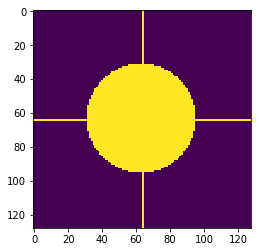

In [3]:
def make_circle():
    x = np.linspace(-63,64,128)
    y = np.linspace(-63,64,128)
    X, Y = np.meshgrid(x,y)
    C = np.zeros([128,128])
    for i in range(128):
        for j in range(128):
            xx = X[i,j]
            yy = Y[i,j]
            if (xx**2 + yy**2 < 32**2):
                C[i,j] = 1;
    C[64,:] = 1; C[:,64] = 1;
    return C
C = make_circle()
plt.imshow(C)

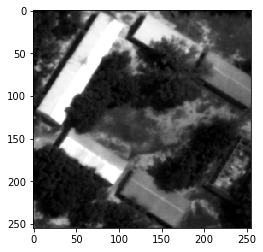

In [38]:
I = plt.imread('./png_satellite_image/6100_0_3_gray.png')
I = I[:,:,1]
row_ind = 2400
col_ind = 1860
A = np.zeros(I.shape[0:1])
I1 = I[row_ind:row_ind+255, col_ind:col_ind+255]

plt.imshow(I1,cmap='gray')

## 2-Dimensional Continuous Wavelet Transform

In [39]:
def cwt_2d(I, scale):
    N = I.shape[0]
    
    H = np.zeros([N,N])
    V = np.zeros([N,N])
    
    wavelet, t = gaus1(N,1,scale)
    
    for i in range(N):
        H[i,:] = signal.fftconvolve(I[i,:], wavelet, 'same')
    for i in range(N):
        V[:,i] = signal.fftconvolve(I[:,i], wavelet, 'same')
    return H, V

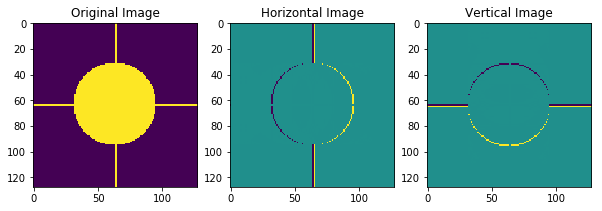

In [40]:
H0, V0 = cwt_2d(C, 0.01)
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=[10,6])
ax0.imshow(C)
ax0.set_title('Original Image')
ax1.imshow(H0)
ax1.set_title('Horizontal Image')
ax2.imshow(V0)
ax2.set_title('Vertical Image')

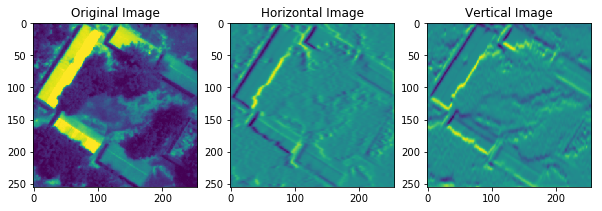

In [41]:
H1, V1 = cwt_2d(I1, 0.1)
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=[10,6])
ax0.imshow(I1)
ax0.set_title('Original Image')
ax1.imshow(H1)
ax1.set_title('Horizontal Image')
ax2.imshow(V1)
ax2.set_title('Vertical Image')

## Wavelet Transform Modulus Maxima in 2-Dimension

In [42]:
def wtmm_2d(H, V):
    M = np.sqrt(H**2 + V**2)
    N = M.shape[1]
    
    A = V / H
    A = np.arctan(A)
    ind = np.where(H<0)
    
    ind1 = np.tan(22.5/180*np.pi)
    ind2 = np.tan(67.5/180*np.pi)
    
    MM = np.zeros([N,N])
    
    for i in range(1,N-2):
        for j in range(1,N-2):
            p = M[i,j]
            p1 = []; p2 = []
            if np.abs(A[i,j]) >= ind2:
                p1 = M[i+1,j]; p2 = M[i-1,j]
                if (p-p1)*(p-p2) >= 0:
                    MM[i,j] = p;
            elif np.abs(A[i,j]) <= ind1:
                p1 = M[i,j+1]; p2 = M[i,j-1]
                if (p-p1)*(p-p2) >= 0:
                    MM[i,j] = p;
            elif (A[i,j]>ind1) & (A[i,j]<ind2):
                p1 = M[i+1,j+1]; p2 = M[i-1,j-1]
                if (p-p1)*(p-p2) >= 0:
                    MM[i,j] = p;
#             elif (A[i,j]>=-ind2) & (A[i,j]<=-ind1):
            elif (A[i,j]>-ind2) & (A[i,j]<-ind1):
                p1 = M[i+1,j-1]; p2 = M[i-1,j+1]
                if (p-p1)*(p-p2) >= 0:
                    MM[i,j] = p;
    A[ind] = A[ind] + np.pi
    return M, A, MM

/Users/lida/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide


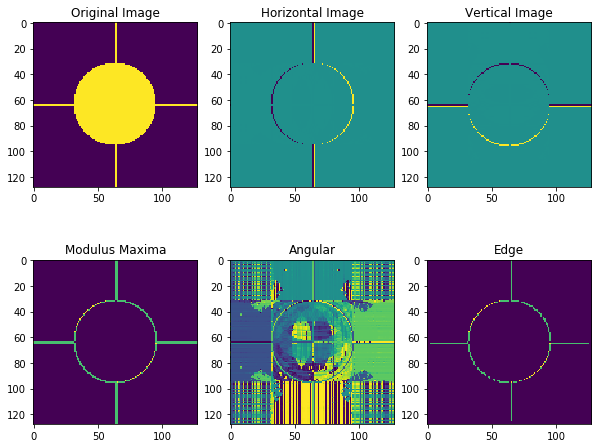

In [43]:
M0, A0, MM0 = wtmm_2d(H0, V0)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[10,8])
axes[0,0].imshow(C)
axes[0,0].set_title('Original Image')
axes[0,1].imshow(H0)
axes[0,1].set_title('Horizontal Image')
axes[0,2].imshow(V0)
axes[0,2].set_title('Vertical Image')
axes[1,0].imshow(M0)
axes[1,0].set_title('Modulus Maxima')
axes[1,1].imshow(A0)
axes[1,1].set_title('Angular')
axes[1,2].imshow(MM0)
axes[1,2].set_title('Edge')

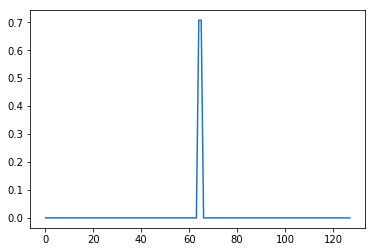

In [44]:
plt.plot(M0[30,:])

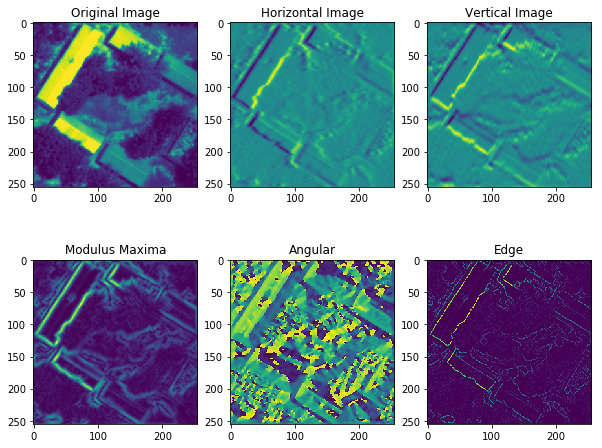

In [45]:
M1, A1, MM1 = wtmm_2d(H1, V1)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[10,8])
axes[0,0].imshow(I1)
axes[0,0].set_title('Original Image')
axes[0,1].imshow(H1)
axes[0,1].set_title('Horizontal Image')
axes[0,2].imshow(V1)
axes[0,2].set_title('Vertical Image')
axes[1,0].imshow(M1)
axes[1,0].set_title('Modulus Maxima')
axes[1,1].imshow(A1)
axes[1,1].set_title('Angular')
axes[1,2].imshow(MM1)
axes[1,2].set_title('Edge')

## Edge Detection in Different Scale

In [46]:
scale = np.linspace(0.05,0.5,6)

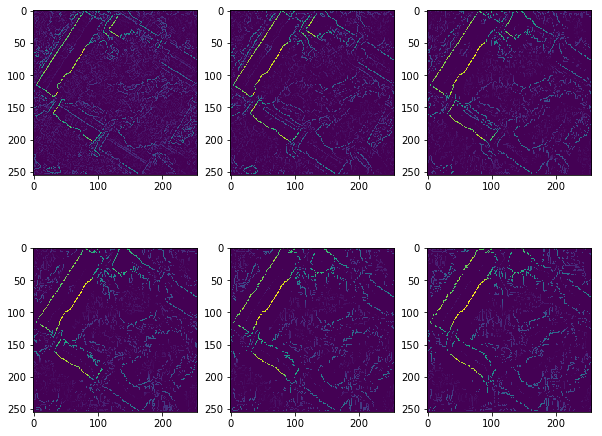

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[10,8])
for ax,i in zip(axes.flat, range(len(scale))):
    s = scale[i]
    H, V = cwt_2d(I1, s)
    M, A, MM = wtmm_2d(H, V)
    ax.imshow(MM)

## Calculate Multiple Edges

In [48]:
scale = np.linspace(-6, -2, 8);
scale = 2**scale
print(scale)

[ 0.015625    0.02321866  0.0345028   0.05127096  0.07618835  0.11321546
  0.16823752  0.25      ]


In [49]:
def cal_multi_edge(I, scale):
    E = np.ndarray([I.shape[0],I.shape[1],scale.shape[0]])
    for i in range(scale.shape[0]):
        H, V = cwt_2d(I, scale[i])
        M, A, E[:,:,i] = wtmm_2d(H, V)
    return E

/Users/lida/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/Users/lida/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


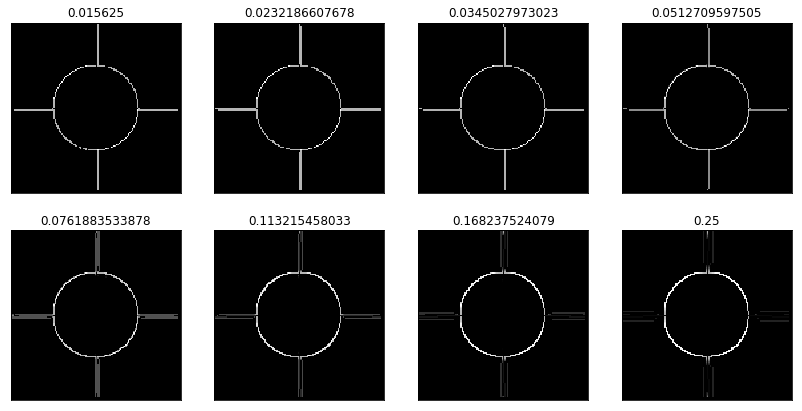

In [50]:
E0 = cal_multi_edge(C, scale)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[14,7])
for ax,i in zip(axes.flat, range(len(scale))):
    ax.imshow(E0[:,:,i], cmap='gray')
    ax.set_title(str(scale[i]))
    ax.set_xticks([])
    ax.set_yticks([])

/Users/lida/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide


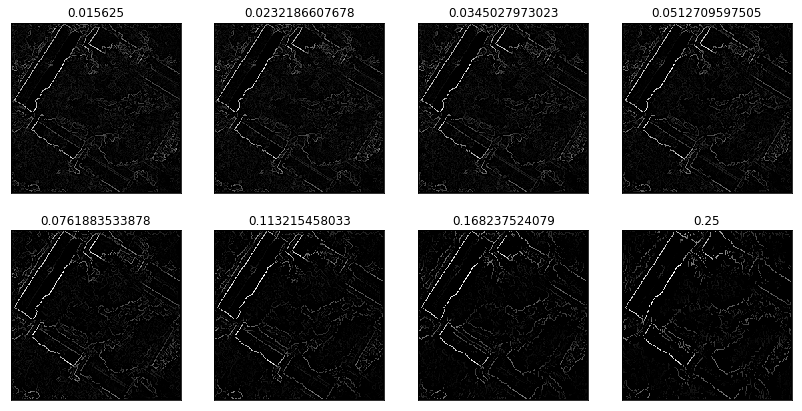

In [51]:
E1 = cal_multi_edge(I1, scale)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[14,7])
for ax,i in zip(axes.flat, range(len(scale))):
    ax.imshow(E1[:,:,i], cmap='gray')
    ax.set_title(str(scale[i]))
    ax.set_xticks([])
    ax.set_yticks([])

In [52]:
scale = np.linspace(-6, -3, 16);
scale = 2**scale

v = 20; h = 65

I = MM0
E = cal_multi_edge(C, scale)
th = 0.1

ind = np.where(np.abs(I) > th * np.max(I))
ind_x = ind[1]
ind_y = ind[0]

val = np.zeros([len(scale), len(ind[0])])
val[0,:] = I[ind]

/Users/lida/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/Users/lida/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


In [53]:
for i in range(1,E.shape[2]):
    I = E[:,:,i]
    for j in range(len(ind_x)):
        x_coor = ind_x[j]
        y_coor = ind_y[j]
        if I[x_coor, y_coor] > th*np.max(I):
            val[i,j] = I[x_coor, y_coor]
        elif I[x_coor, y_coor-1] > th*np.max(I):
            val[i,j] = I[x_coor, y_coor-1]
            ind_x[j] = x_coor
            ind_y[j] = y_coor-1
        elif I[x_coor, y_coor+1] > th*np.max(I):
            val[i,j] = I[x_coor, y_coor+1]
            ind_x[j] = x_coor
            ind_y[j] = y_coor+1
        elif I[x_coor+1, y_coor] > th*np.max(I):
            val[i,j] = I[x_coor+1, y_coor]
            ind_x[j] = x_coor+1
            ind_y[j] = y_coor
        elif I[x_coor+1, y_coor-1] > th*np.max(I):
            val[i,j] = I[x_coor+1, y_coor-1]
            ind_x[j] = x_coor+1
            ind_y[j] = y_coor-1
        elif I[x_coor+1, y_coor+1] > th*np.max(I):
            val[i,j] = I[x_coor+1, y_coor+1]
            ind_x[j] = x_coor+1
            ind_y[j] = y_coor+1
        elif I[x_coor-1, y_coor] > th*np.max(I):
            val[i,j] = I[x_coor-1, y_coor]
            ind_x[j] = x_coor-1
            ind_y[j] = y_coor
        elif I[x_coor-1, y_coor-1] > th*np.max(I):
            val[i,j] = I[x_coor-1, y_coor-1]
            ind_x[j] = x_coor-1
            ind_y[j] = y_coor-1
        elif I[x_coor-1, y_coor+1] > th*np.max(I):
            val[i,j] = I[x_coor-1, y_coor+1]
            ind_x[j] = x_coor-1
            ind_y[j] = y_coor+1

In [54]:
val1 = np.zeros(val.shape)
for i in range(val.shape[0]):
    val1[i,:] = np.log2(val[i,:])
val1

array([[-0.5       , -0.5       , -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.5       , -0.5       , -0.5       , ..., -0.5       ,
        -0.5       , -0.5       ],
       ..., 
       [-1.43762317, -1.43762317, -1.43762317, ..., -1.43762317,
        -1.43762317, -1.43762317],
       [-1.70743037, -1.70743037, -1.70743037, ..., -1.70743037,
        -1.70743037, -1.70743037],
       [-1.98456674, -1.98456674, -1.98456674, ..., -1.98456674,
        -1.98456674, -1.98456674]])

In [55]:
y = val1[:,3]
drop_inf = np.isinf(y)
y = y[~drop_inf]
scale1 = np.log2(scale)
x = scale1[~drop_inf]
A = np.ones([y.shape[0],2])
A[:,0] = x

m, c = np.linalg.lstsq(A,y)[0]
m

-0.43298825885733705

In [141]:
def LE_2d(E, scale, th):
    I = E[:,:,0]
    
    ind = np.where(np.abs(I) > th * np.max(I))
    ind_x = ind[1]
    ind_y = ind[0]

    val = np.zeros([len(scale), len(ind[0])])
    
    val[0,:] = I[ind]
    
    for i in range(1,E.shape[2]):
        I = E[:,:,i]
        for j in range(len(ind_x)):
            x_coor = ind_x[j]
            y_coor = ind_y[j]
            if x_coor>0 & y_coor>0:
                if I[x_coor, y_coor] > th*np.max(I):
                    val[i,j] = I[x_coor, y_coor]
                elif I[x_coor, y_coor-1] > th*np.max(I):
                    val[i,j] = I[x_coor, y_coor-1]
                    ind_x[j] = x_coor
                    ind_y[j] = y_coor-1
                elif I[x_coor, y_coor+1] > th*np.max(I):
                    val[i,j] = I[x_coor, y_coor+1]
                    ind_x[j] = x_coor
                    ind_y[j] = y_coor+1
                elif I[x_coor+1, y_coor] > th*np.max(I):
                    val[i,j] = I[x_coor+1, y_coor]
                    ind_x[j] = x_coor+1
                    ind_y[j] = y_coor
                elif I[x_coor+1, y_coor-1] > th*np.max(I):
                    val[i,j] = I[x_coor+1, y_coor-1]
                    ind_x[j] = x_coor+1
                    ind_y[j] = y_coor-1
                elif I[x_coor+1, y_coor+1] > th*np.max(I):
                    val[i,j] = I[x_coor+1, y_coor+1]
                    ind_x[j] = x_coor+1
                    ind_y[j] = y_coor+1
                elif I[x_coor-1, y_coor] > th*np.max(I):
                    val[i,j] = I[x_coor-1, y_coor]
                    ind_x[j] = x_coor-1
                    ind_y[j] = y_coor
                elif I[x_coor-1, y_coor-1] > th*np.max(I):
                    val[i,j] = I[x_coor-1, y_coor-1]
                    ind_x[j] = x_coor-1
                    ind_y[j] = y_coor-1
                elif I[x_coor-1, y_coor+1] > th*np.max(I):
                    val[i,j] = I[x_coor-1, y_coor+1]
                    ind_x[j] = x_coor-1
                    ind_y[j] = y_coor+1
                else:
                    ind_x[j] = -9999
                    ind_y[j] = -9999
            
    val1 = np.zeros(val.shape)
    for i in range(val.shape[0]):
        val1[i,:] = np.log2(val[i,:])
        
    alpha = np.zeros(val1.shape[1])
    scale1 = np.log2(scale)
    for i in range(val1.shape[1]):
        y = val1[:,i]
        drop_inf = np.isinf(y)
        y = y[~drop_inf]
        x = scale1[~drop_inf]
        A = np.ones([y.shape[0],2])
        A[:,0] = x
        m, c = np.linalg.lstsq(A,y)[0]
        alpha[i] = m - 1
        
    ind = np.where(np.abs(E[:,:,0]) > th * np.max(E[:,:,0]))
    
    return alpha, ind, val1, scale1

def ex_edge_by_Lip(E, alpha, index, th):
    II = E[:,:,0]
    A = np.zeros(II.shape)
    Lip = np.zeros(II.shape)
    E_one = np.zeros(II.shape)
    E_val = np.zeros(II.shape)
    A[ind] = a
    index = np.where(A<th)
    Lip[index] = A[index]
    E_one[index] = 1
    E_val[index] = II[index]
    return Lip, E_one, E_val

In [160]:
a, ind, val, s = LE_2d(E1, scale, 0.1)

th = np.linspace(-0.7,-0.35,8)
Lip1 = np.ndarray([E1.shape[0], E1.shape[1], 8])
E_one1 = np.ndarray([E1.shape[0], E1.shape[1], 8])
E_val1 = np.ndarray([E1.shape[0], E1.shape[1], 8])
for i in range(8):
    Lip1[:,:,i], E_one1[:,:,i], E_val1[:,:,i] = ex_edge_by_Lip(E1, a, ind, th[i])

/Users/lida/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log2


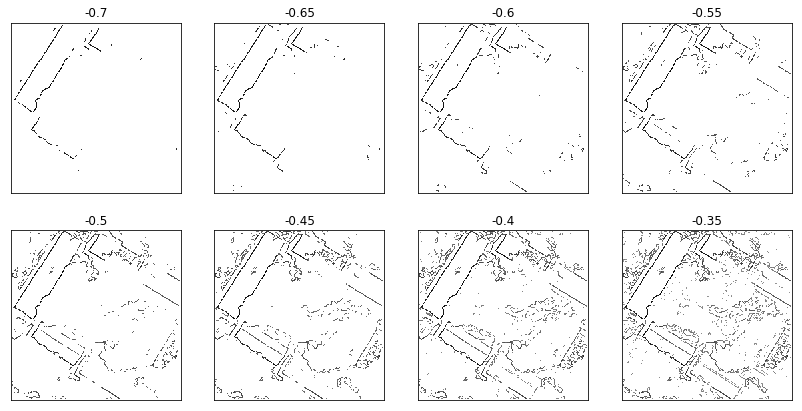

In [161]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[14,7])
for ax,i in zip(axes.flat, range(8)):
    ax.imshow(Lip1[:,:,i], cmap='gray')
    ax.set_title(str(th[i]))
    ax.set_xticks([])
    ax.set_yticks([])

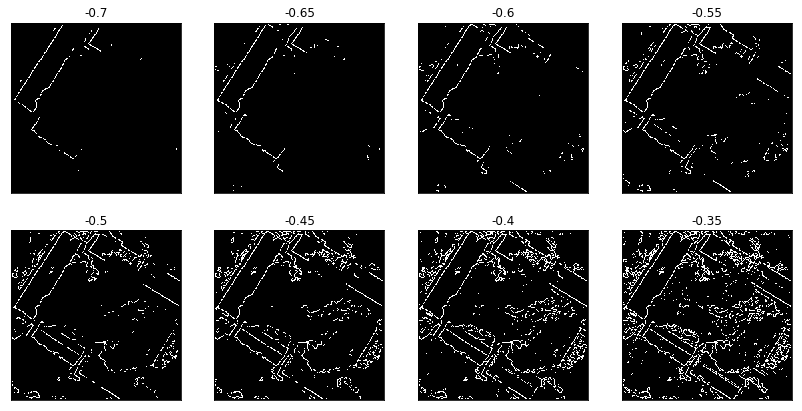

In [162]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[14,7])
for ax,i in zip(axes.flat, range(8)):
    ax.imshow(E_one1[:,:,i], cmap='gray')
    ax.set_title(str(th[i]))
    ax.set_xticks([])
    ax.set_yticks([])

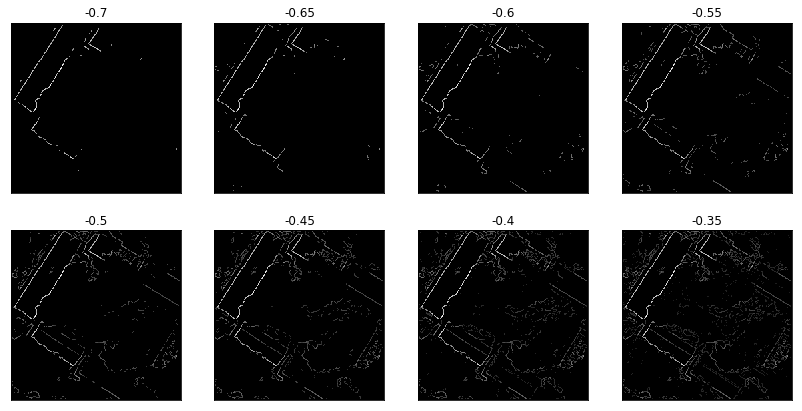

In [163]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=[14,7])
for ax,i in zip(axes.flat, range(8)):
    ax.imshow(E_val1[:,:,i], cmap='gray')
    ax.set_title(str(th[i]))
    ax.set_xticks([])
    ax.set_yticks([])